In [15]:
# Multiple outputs per cell in Jupyter 
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
%load_ext autoreload
%autoreload 2
from skeleton import *
from sklearn.metrics import (recall_score, f1_score,
                             precision_score, accuracy_score)

In [2]:
from sklearn.datasets import make_blobs, make_circles,load_iris
blobs_X, blobs_y = make_blobs(centers=2, random_state=3)
print('X ~ n_sambles x n_features:', blobs_X.shape)
print('y ~ n_samples:', blobs_y.shape)
print('\n5 primeros ejemplos:\n', blobs_X[:5, :])
print('\n5 primeras etiquetas:', blobs_y[:5])

X ~ n_sambles x n_features: (100, 2)
y ~ n_samples: (100,)

5 primeros ejemplos:
 [[-3.75593847  0.06753833]
 [-2.94843418  0.3655385 ]
 [-3.36709068 -0.30343965]
 [ 1.89024377  2.86941982]
 [-4.77040684 -1.33000372]]

5 primeras etiquetas: [1 1 1 0 1]


Como los datos son en dos dimensiones, podemos representar cada punto en un sistema de coordenadas (ejes x e y).

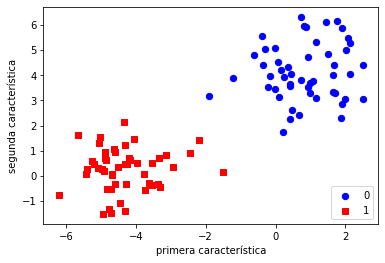

In [3]:
plt.scatter(blobs_X[blobs_y == 0, 0], blobs_X[blobs_y == 0, 1], 
            c='blue', s=40, label='0')
plt.scatter(blobs_X[blobs_y == 1, 0], blobs_X[blobs_y == 1, 1], 
            c='red', s=40, label='1', marker='s')

plt.xlabel('primera característica')
plt.ylabel('segunda característica')
plt.legend(loc='lower right');

Como ya mencionamos la clasificación es una tarea supervisada y, ya que estamos interesados en su rendimiento en datos no utilizados para entrenar, vamos a dividir los datos en dos partes:

1. un conjunto de entrenamiento que el algoritmo de aprendizaje utiliza para ajustar los parámetros del modelo
2. un conjunto de test para evaluar la capacidad de generalización del modelo (como se comportaba con datos nuevos, previamente no tratados, lo que podemos denominar una *prueba de realidad*).

||
|:---:|
|**División en entrenamiento  y  prueba**|

La función ``train_test_split`` del paquete ``model_selection`` hace justo esto por nosotros - la usaremos para generar una partición con un 70%//30% en entrenamiento y test, respectivamente.

In [4]:
from sklearn.model_selection import train_test_split
blobs_X_train,blobs_X_test,blobs_y_train,blobs_y_test = train_test_split(blobs_X, blobs_y,
                                                    test_size=0.30,
                                                    random_state=3,
                                                    stratify=blobs_y)

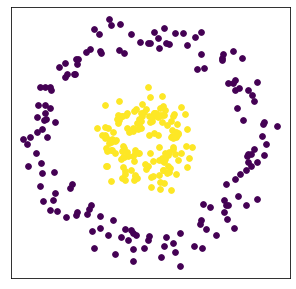

In [5]:
#Generamos los datos
circles_X,circles_y= make_circles(n_samples=300, noise=0.1, random_state=2, factor=0.3)
plotClusters(circles_X,circles_y)

In [6]:
#Particionamos en train y test
circles_X_train,circles_X_test, circles_y_train, circles_y_test = train_test_split(circles_X, circles_y,
                                                    test_size=0.30,
                                                    random_state=3,
                                                    stratify=circles_y)

In [7]:
## Cargamos el dataset de plantas de Iris
iris = load_iris()
iris_X, iris_y = iris.data, iris.target
#Divididmos en entremamiento y prueba
iris_X_train, iris_X_test, iris_y_train, iris_y_test = train_test_split(iris_X, iris_y,
                                                    test_size=0.30,
                                                    random_state=3,
                                                    stratify=iris_y)

## Clasificador $k$ Nearest Neighbor

El clasificador $k$ nearest neighbor ($k$NN), es un método no paramétrico que utiliza todos ejemplos en el conjunto de entrenamiento para predecir la clase de los ejemplos no etiquetados. Por lo que no hay fase de entrenamiento, la predicción se realiza mediante el uso de una función de similitud/distancia.

El clasificador $k$NN es simple e intuitivo, para $k=1$ funciona como sigue: dado un vector $x_q$, se le asocia la clase $\theta_q$ que será la misma que tenga el elemento más similar a $x_{nn} \in X$ más similar a $x_q$. El objeto $x_{nn}$ se determina como  $\arg\!\max_{1 \leq i \leq |X|} \cos (x_q, x_i)$ cuando se utiliza la similitud coseno o bien como $\arg\!\min_{1 \leq i \leq |X|} d(u, x_i)$  cuando se utiliza una función de distancia. Lo anterior da el origen al nombre desde que para determinar la clase de un objeto no etiquetado, primero debe encontrarse su vecino más cercano.  Una mejora directa es utilizar más de un vecino para calcular la clase de $x_q$, es decir utilizar $k>1$. Para $k>1$ se puede asignar a $x_q$ la clase que más se repita entre los $k$ vecinos más cercanos de $x_q$ (**pesado uniforme**).

|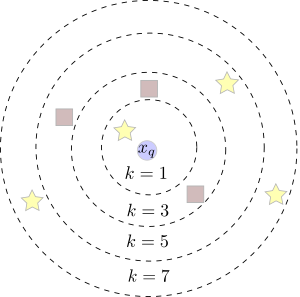|
|:--:|
|**Consulta $k$NN para diferentes valores de $k$**|

### Pesado de vecinos por distancia

También es común realizar un pesado de la contribución de cada vecino basados en el valor de la función de distancia o similitud. Para nuestro caso solo utilizaremos dos variantes simples. 

-  **$k$NN distancia/similitud media**: En este caso se asigna a  $x_q$ la clase en la que la distancia media de los $k$ vecinos seleccionados sea menor. Mientras que se utiliza el valor mayor cuando se utiliza una función de similitud.
- **$k$NN pesado por distancia**: Una forma básica de pesar cuando se utiliza una función de distancia es asignar a cada etiqueta un peso equivalente al inverso de la distancia. En el caso de la similitud puede ser el valor normalizado de la misma(cuando se usa coseno el valor ya está entre 0 y 1). Se asigna la clase que tenga el mayor peso.

Por ejemplo suponga que la información de cinco vecinos más cercanos para un $x_q$ dado en problema de 3 clases se resumen en la siguiente tabla. 

|&nbsp;|$x_1$|$x_2$|$x_3$|$x_4$|$x_5$|
|:------------:|:---:|:---:|:---:|:---:|:---:|
|Clase de $x_i$|  2  |  1  |  2  |  1  |  0  |
|$$d(x_i,x_q)$$| 0.5 | 0.2 |0.25 | 0.4 |0.125|
|$$w_{x_i}$$       |  2  |  5  |  4  | 2.5 |  8  |

en las siguiente tabla se muestra como se calculan los scores para cada clase

| <br /> | distancia media                    | pesado por distancia |uniforme|
|:------:|:---------------------------------: |:--------------:       |:----:|
|Clase 0 |  $d(x_5,x_q)/1$=**0.125**          |$w_{x_0}$=**8**            |   1  |
|Clase 1 |  $$(d(x_2,x_q)+d(x_4,x_q))/2=0.3$$   |$$w_{x_2}+w_{x_4}=7.5$$|   **2**  |
|Clase 2 |  $$(d(x_1,x_q)+d(x_3,x_q))/2=0.225$$ |$$w_{x_1}+w_{x_3}=6$$  |   **2**  |

usando la información en la tabla anterior podemos ver que para $k=5$, si se utiliza el criterio de la distancia mínimo promedio la clase para $x_q$ sería 0, al igual que para el pesado por distancia; mientras que para la decisión por mayoría de votos podría ser la clase 1 o 2. 

**Nota**: Si se utiliza una función de similitud no es necesario calcular el inverso, pero es buena idea normalizar.

- Se proporciona solución  mediante el uso de indices implementados en la librería **faiss**. En este caso la fase de entrenamiento consiste en generar el indice para los datos de entrenamiento.
- La versión **bruta/lineal** de $k$NN,  cada que se predice se debe calcular la distancia con respecto a todos los elementos en el conjunto de entrenamiento para determinar los $k$  más cercano. En este caso la fase de entrenamiento no se realiza, pero la predicción es costosa.


In [56]:
blobs_X_test[:3].shape

(3, 2)

In [69]:
#Probamos el clasificador con pesado uniforme con el ejemplo de los blobs
nn_clf=kNN(k=3,weight_type="uniform").fit(
    blobs_X_train[:10],blobs_y_train[:10])
nn_clf.predict(blobs_X_test[:5])

array([0, 1, 0, 0, 1])

In [70]:
#Probamos el clasificador con pesado uniforme con el ejemplo de los blobs
nn_clf=kNN(k=3,weight_type="meanDist").fit(
    blobs_X_train[:10],blobs_y_train[:10])
nn_clf.predict(blobs_X_test[:5])

Implementación _meanDist


array([0, 0, 0, 0, 0])

In [68]:
nn_clf.n_ids
nn_clf.n_dists
nn_clf.labels

array([[4, 8, 2],
       [6, 9, 0],
       [8, 4, 2],
       [7, 3, 2],
       [6, 9, 0]])

array([[0.99482083, 0.95991486, 0.9491259 ],
       [0.9990292 , 0.9890786 , 0.9704415 ],
       [0.9839428 , 0.97876024, 0.97682774],
       [0.9992845 , 0.9952343 , 0.9900608 ],
       [0.9977242 , 0.9853573 , 0.97582513]], dtype=float32)

array([1, 0, 0, 0, 0, 1, 1, 0, 0, 1])

In [35]:
it=np.nditer(nn_clf.n_ids, flags=['c_index'])
while not it.finished:
    print("%d <%d>" % (it[0], it.index), end=' ')
    _=it.iternext()

4 <0> 2 <1> 3 <2> 0 <3> 1 <4> 3 <5> 

In [59]:
labels=[]
for i in range(blobs_X_test[:2].shape[0]):
    n_class=[]
    for n_id in nn_clf.n_ids:
        row=[]
        for id_ in n_id:
            row.append(nn_clf.labels[id_])
        n_class.append(row)
    n_class=np.array(n_class)

    lb=list(set(nn_clf.labels))
    mean_dists=[]
    for j in lb:
        mean_dists.append(
            np.mean(nn_clf.n_dists[np.where(n_class==j)])) 
    labels.append(lb[np.argmin(mean_dists)])
labels

[0, 0]

In [72]:
n_class=[]
for n_id in nn_clf.n_ids:
    row=[]
    for id_ in n_id:
        print("%d" % (id_), end=' ')
        row.append(nn_clf.labels[id_])
    n_class.append(row)
n_class=np.array(n_class)
n_class

xc=1
np.where(n_class==xc)
nn_clf.n_dists[np.where(n_class==xc)]
np.mean(nn_clf.n_dists[np.where(n_class==xc)])

lb=list(set(nn_clf.labels))
lb
mean_dists=[]
for j in lb:
    print(j,nn_clf.n_dists[np.where(n_class==j)])
    mean_dists.append(
        np.mean(nn_clf.n_dists[np.where(n_class==j)]))
mean_dists

np.argmin(mean_dists)
lb[np.argmin(mean_dists)]

4 8 2 6 9 0 8 4 2 7 3 2 6 9 0 

array([[0, 0, 0],
       [1, 1, 1],
       [0, 0, 0],
       [0, 0, 0],
       [1, 1, 1]])

(array([1, 1, 1, 4, 4, 4]), array([0, 1, 2, 0, 1, 2]))

array([0.9990292 , 0.9890786 , 0.9704415 , 0.9977242 , 0.9853573 ,
       0.97582513], dtype=float32)

0.9862427

[0, 1]

0 [0.99482083 0.95991486 0.9491259  0.9839428  0.97876024 0.97682774
 0.9992845  0.9952343  0.9900608 ]
1 [0.9990292  0.9890786  0.9704415  0.9977242  0.9853573  0.97582513]


[0.9808858, 0.9862427]

0

0

In [23]:
np.unique(nn_clf.n_ids)

array([0, 1, 2, 3, 4])

In [20]:
lb=list(set(nn_clf.labels))
lb
for j in lb:
#     nn_clf.data[np.where(nn_clf.labels==j)]
    np.where(nn_clf.labels==j)

[0, 1]

(array([1, 2, 3, 4]),)

(array([0]),)

In [9]:
nn_clf.predict(blobs_X_test[:2])

Implementación _meanDist
(2, 3)
[[ 0.99482083  0.9491259   0.9345558 ]
 [ 0.9704415   0.12598658 -0.15575577]]
(2, 3)
[[4 2 3]
 [0 1 3]]
4
0


array([0, 0])

Implementación _meanDist
(4800, 3)
[[ 0.97829604  0.16064112 -0.16406903]
 [ 0.97861886  0.16218448 -0.16252616]
 [ 0.97895026  0.16377999 -0.16093034]
 ...
 [ 0.9999956   0.9482249   0.04685089]
 [ 0.9999341   0.9435413   0.03242591]
 [ 0.99966717  0.9387003   0.01810825]]
(4800, 3)
[[0 1 2]
 [0 1 2]
 [0 1 2]
 ...
 [2 1 0]
 [2 1 0]
 [2 1 0]]
2
0


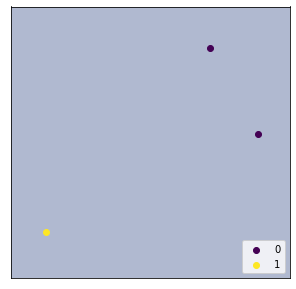

In [24]:
plotDecisionBoundary(
    nn_clf,blobs_X_train[:3],blobs_y_train[:3])

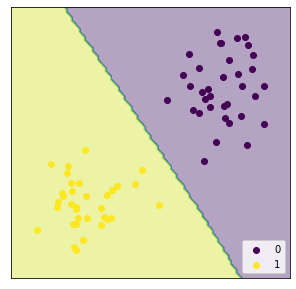

In [9]:
#Probamos el clasificador con pesado uniforme con el ejemplo de los blobs
nn_clf=kNN(k=3,weight_type="uniform").fit(blobs_X_train,blobs_y_train)
plotDecisionBoundary(nn_clf,blobs_X_train,blobs_y_train)

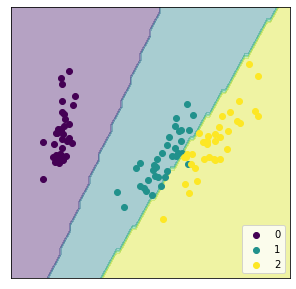

In [10]:
#El data set de Iris
nn_clf=kNN(k=3,weight_type="uniform").fit(iris_X_train,iris_y_train)
plotDecisionBoundary(nn_clf,iris_X_train,iris_y_train)

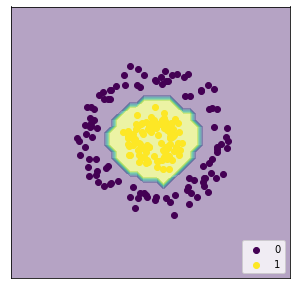

In [11]:
#Dataser de los circulos, utilizando distancia euclidiana
nn_clf=kNN(distance='euclideana', 
           k=3,weight_type="uniform").fit(circles_X_train,circles_y_train)
plotDecisionBoundary(nn_clf,circles_X_train,circles_y_train)

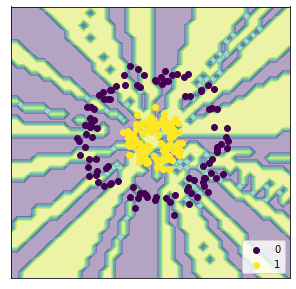

In [12]:
#Dataser de los circulos, utilizando distancia euclidiana
nn_clf=kNN(k=3,distance='coseno',weight_type="uniform").fit(circles_X_train,circles_y_train)
plotDecisionBoundary(nn_clf,circles_X_train,circles_y_train)